#Multivariate LSTM model

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import mysql.connector
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


Constructing the dataset

In [ ]:
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="yahoonet",
    database="AIProject"
)

def make_multivariate_sequences(array, n_steps):
    """array shape: (timesteps, n_features)"""
    X, y = [], []
    for i in range(len(array)-n_steps):
        X.append(array[i:i+n_steps,:])      # n_steps x n_features
        y.append(array[i+n_steps,0])        # predict market_value next
    return np.array(X), np.array(y)

def make_multivariate_multistep(array, n_steps, n_future=3):
    """
    array shape: (timesteps, n_features)
    n_steps = how many past windows
    n_future = how many steps ahead to predict (e.g., next 3 windows)
    """
    X, y = [], []
    for i in range(len(array)-n_steps-n_future+1):
        X.append(array[i:i+n_steps, :])
        y.append(array[i+n_steps:i+n_steps+n_future, 0])  # future market_value only
    return np.array(X), np.array(y)

# --- Load the merged time series ---
# (Here df_t is the transfer history with date & market_value)
# (df_f is the player_features table with static columns)

df_t = pd.read_sql("SELECT transfermarkt_id, transfer_date, market_value FROM player_transfer_history ORDER BY transfermarkt_id, transfer_date", db)
df_f = pd.read_sql("SELECT * FROM player_features", db)

# Merge static features onto each time row
df = df_t.merge(df_f[["player_id","total_injuries","sentiment_mean","avg_cards_per_match","avg_days_out","recent_injury","days_since_last_injury","season_id","minutes_played","shots_per90","pressures_per90"]],
                left_on="transfermarkt_id", right_on="player_id", how="left")

# Sort by time per player
df = df.sort_values(["transfermarkt_id","transfer_date"])

df.head()
from sklearn.preprocessing import MinMaxScaler

# choose which features to scale
#features_cols = ["market_value","total_injuries","sentiment_mean","avg_cards_per_match"]
features_cols = ["market_value","total_injuries","sentiment_mean","avg_cards_per_match","avg_days_out","recent_injury","days_since_last_injury","season_id","minutes_played","shots_per90","pressures_per90"]

# stack all player data first
all_features = df[features_cols].fillna(0).values

global_scaler = MinMaxScaler()
global_scaler.fit(all_features)   # fit ONCE across entire dataset

n_steps = 3
n_future = 3
X_list, y_list, player_index = [], [], []

for pid, group in df.groupby("transfermarkt_id"):
    features = group[features_cols].fillna(0).values
    scaled = global_scaler.transform(features)  # use global scaler now
    
    #Xp, yp = make_multivariate_sequences(scaled, n_steps)
    Xp, yp = make_multivariate_multistep(scaled, n_steps, n_future)
    if len(Xp)==0:
        continue
    X_list.append(Xp)
    y_list.append(yp)
    player_index.extend([pid]*len(yp))
    

# Stack across all players
#X = np.vstack(X_list)   # shape: (samples, n_steps, n_features)
#y = np.concatenate(y_list)  # shape: (samples,)

X = np.vstack(X_list)   # (samples, n_steps, n_features)
y = np.vstack(y_list)   # (samples, n_future)



C:\Users\Himanshu Saxena\AppData\Local\Temp\ipykernel_30288\153956508.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_t = pd.read_sql("SELECT transfermarkt_id, transfer_date, market_value FROM player_transfer_history ORDER BY transfermarkt_id, transfer_date", db)
C:\Users\Himanshu Saxena\AppData\Local\Temp\ipykernel_30288\153956508.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_f = pd.read_sql("SELECT * FROM player_features", db)


Check for missing values

In [3]:
print(df.isnull().sum())

transfermarkt_id          0
transfer_date             0
market_value              0
player_id                 0
total_injuries            0
sentiment_mean            0
avg_cards_per_match       0
avg_days_out              0
recent_injury             0
days_since_last_injury    0
season_id                 0
minutes_played            0
shots_per90               0
pressures_per90           0
dtype: int64


LSTM Building

Epoch 1/50


C:\Users\Himanshu Saxena\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0024


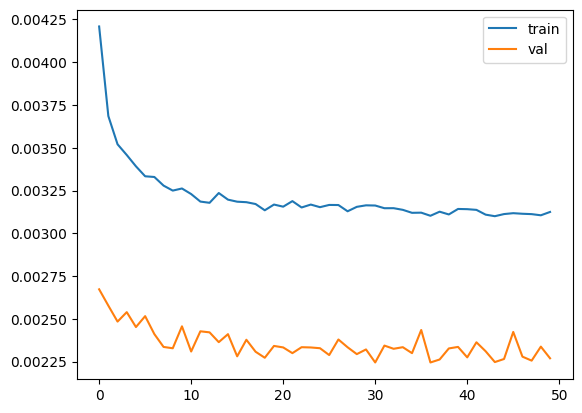

In [4]:
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(n_future))   # output n_future steps
model.compile(optimizer='adam', loss='mse')
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, shuffle=True)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()



Training + Loss curves

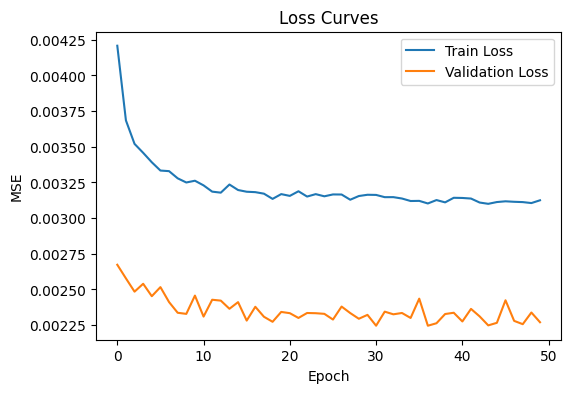

In [5]:
# Plot loss curves
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Loss Curves')
plt.show()


RMSE

In [6]:
# Evaluate RMSE on validation set

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(n_future))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val,y_val))

y_pred = model.predict(X_val)

# compute RMSE for each horizon
rmse_per_step = np.sqrt(np.mean((y_val - y_pred)**2, axis=0))
print("RMSE per forecast step:", rmse_per_step)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_lo

Prediction

--------------------------------
Predicting for player ID: 28396
--------------------------------
[   8198    8198    8198 ... 1145504 1145504 1190411]
[False False False ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Step 1 predictions in original market_value scale: [ 2633937.29925156  2633937.29925156  6430976.31633282 29633790.85063934
 18915123.04544449 13909850.12054443 14471059.44156647]
Step 2 predictions in original market_value scale: [ 6506324.93197918  6506324.93197918  9557196.19989395 28265322.44682312
 19293522.387743   14609320.61076164 15390383.89921188]
Step 3 predictions in original market_value scale: [11303174.79372025 11303174.79372025 13687348.81281853 28054634.9287033
 19663494.22931671 15981664.80660438 17028831.39252663]
True values: [[0.         0.02222222 0.16666667]
 [0.02222222 0.16666667 0.11111111]
 [0.16666667 0.11111111 0.08333333]
 [0.11111111 0.08333333 0.08333333]
 [0.08333333 0.08333333 0.0222222

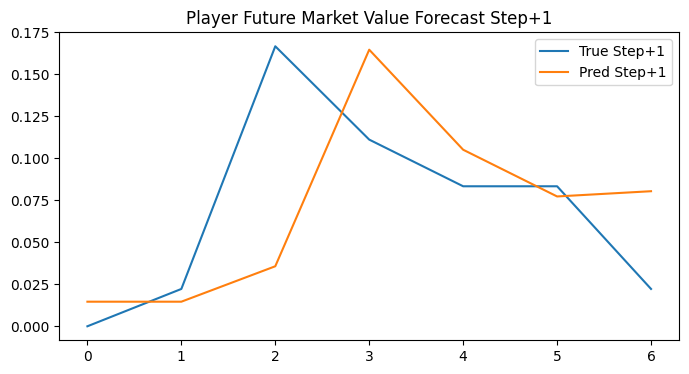

----------------Step + 2----------------


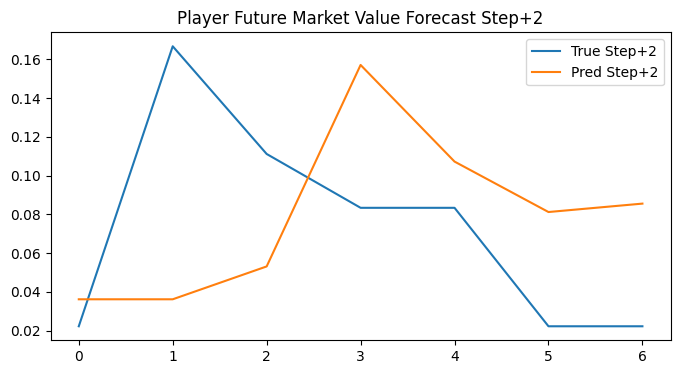

----------------xxxxx----------------
--------------------------------
Predicting for player ID: 8198
--------------------------------
[   8198    8198    8198 ... 1145504 1145504 1190411]
[ True  True  True ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Step 1 predictions in original market_value scale: [ 3584694.89961863  3584694.89961863  3584694.89961863  3584694.89961863
  3584694.89961863 55963942.4085617  69802891.01600647]
Step 2 predictions in original market_value scale: [ 8687353.13415527  8687353.13415527  8687353.13415527  8687353.13415527
  8687353.13415527 50714161.99207306 61193075.1800537 ]
Step 3 predictions in original market_value scale: [14487805.81355095 14487805.81355095 14487805.81355095 14487805.81355095
 14487805.81355095 46633111.23847961 50755763.05389404]
True values: [[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.33333333]
 [0.         0.33333333 0.555555

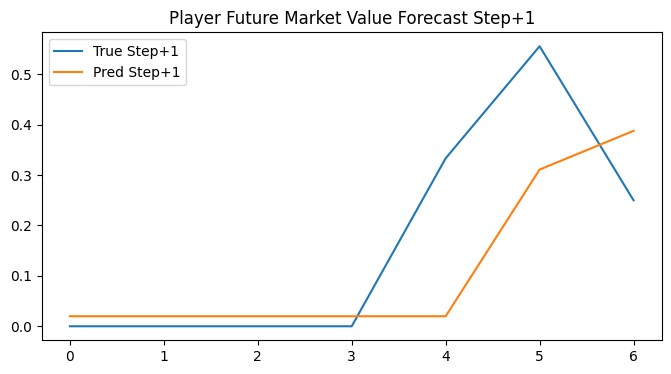

----------------Step + 2----------------


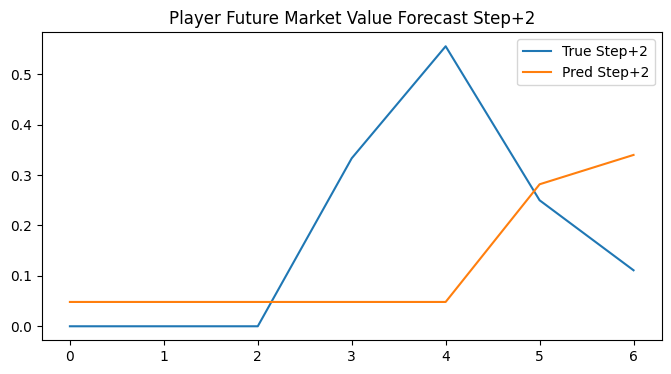

----------------xxxxx----------------
--------------------------------
Predicting for player ID: 8198
--------------------------------
[   8198    8198    8198 ... 1145504 1145504 1190411]
[ True  True  True ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Step 1 predictions in original market_value scale: [ 3584694.89961863  3584694.89961863  3584694.89961863  3584694.89961863
  3584694.89961863 55963942.4085617  69802891.01600647]
Step 2 predictions in original market_value scale: [ 8687353.13415527  8687353.13415527  8687353.13415527  8687353.13415527
  8687353.13415527 50714161.99207306 61193075.1800537 ]
Step 3 predictions in original market_value scale: [14487805.81355095 14487805.81355095 14487805.81355095 14487805.81355095
 14487805.81355095 46633111.23847961 50755763.05389404]
True values: [[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.33333333]
 [0.         0.33333333 0.555555

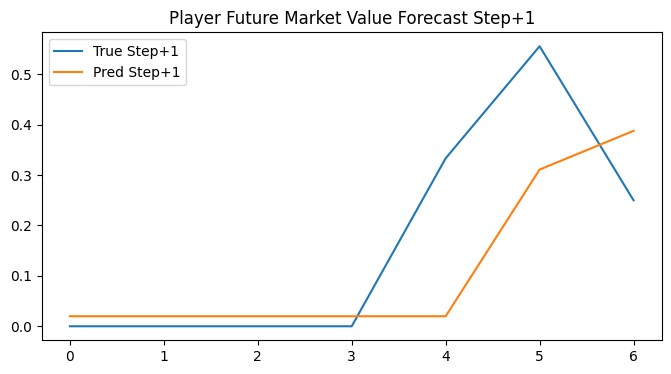

----------------Step + 2----------------


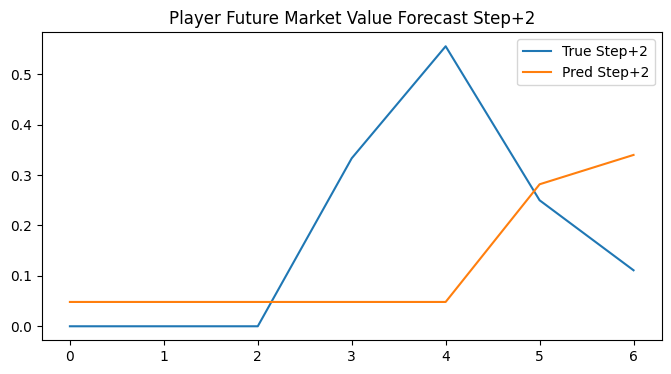

----------------xxxxx----------------


In [7]:
player_id = 28396
default_value = f"{player_id}"
user_input = default_value
while user_input.isdigit(): 
    user_input = input(f"Enter something (default: {default_value}).\n Enter any non-numeric value (eg:Stop) to stop predictions: ") or default_value
    if user_input.isdigit():
        pid = int(user_input)

    if pid not in df.transfermarkt_id.values:
        print("--------------------------------")
        print("Player ID not found in data. Please try another ID.")
        print("--------------------------------") 
        #exit()
    else:
        try:
            print("--------------------------------")
            print("Predicting for player ID:", pid)
            print("--------------------------------")
            print(np.array(player_index))
            mask = np.array(player_index)==pid
            print(mask)
            X_player = X[mask]
            y_true = y[mask]
            y_pred = model.predict(X_player)
            y_pred_scaled = model.predict(X_player)

            # we only scaled the first column (market_value) for y
            # create dummy array to inverse transform
            dummy = np.zeros((y_pred_scaled.shape[0], len(features_cols)))

            # fill dummy’s first column with predicted values
            for step in range(n_future):
                dummy[:,0] = y_pred_scaled[:,step]
                inv = global_scaler.inverse_transform(dummy)
                y_pred_original = inv[:,0]
                print(f"Step {step+1} predictions in original market_value scale:", y_pred_original[:10])

            print("True values:", y_true)
            print("Predicted values:", y_pred.flatten())
            print("--------------------------------")
            selected_rows = df.loc[df['transfermarkt_id'] == pid]
            print("--------------------------------")
            print(selected_rows)
            print("----------------Step + 1----------------")
            plt.figure(figsize=(8,4))
            plt.plot(y_true[:,0], label='True Step+1')
            plt.plot(y_pred[:,0], label='Pred Step+1')
            plt.legend(); plt.title("Player Future Market Value Forecast Step+1")
            plt.show()
            print("----------------Step + 2----------------")
            plt.figure(figsize=(8,4))
            plt.plot(y_true[:,1], label='True Step+2')
            plt.plot(y_pred[:,1], label='Pred Step+2')
            plt.legend(); plt.title("Player Future Market Value Forecast Step+2")
            plt.show()
            print("----------------xxxxx----------------")
        except Exception as e:
            print("Error during prediction:", e)
            print("--------------------------------")
